In [1]:
!pip install -U gdown ultralytics scikit-learn albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 27.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


## 0. Download dataset

In [2]:
# # Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=e24036b1-d48e-437d-a2bb-8427462ffe81
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 76.1MB/s]


## 1. Import libraries

In [ ]:
# %pip install -q -U ultralytics

In [3]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [ ]:
# You can run this to check if the model is working
# !yolo predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg'

In [4]:
import os
import shutil
import xml.etree.ElementTree as ET

import yaml
from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in YOLO format

In [5]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [6]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [7]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


## 3. Convert to YOLO format

In [8]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [9]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

## 4. Train, val, test split

In [10]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

## 5. Save data

In [11]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [12]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

## 6. Create yaml file

In [17]:
data_yaml = {
    "path": os.path.join(os.getcwd(), save_yolo_data_dir),
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## 7. Training

In [18]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 140MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 322MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1209.31it/s]

train: New cache created: /content/datasets/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 177.89it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 400.78it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 46.70it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.61G      1.972      2.911      1.755         28        640: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         43        200      0.644      0.615      0.583      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.63G      1.244      1.529       1.16         81        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         43        200       0.59       0.65      0.649      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.64G      1.191      1.253      1.165         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         43        200      0.301      0.195      0.122     0.0551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.56G      1.321       1.31      1.228         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         43        200    0.00272      0.085     0.0066    0.00146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.73G      1.342      1.225      1.259         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         43        200    0.00495       0.12    0.00235   0.000667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.74G      1.276      1.239      1.234         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         43        200    0.00428        0.2    0.00266   0.000599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       8.6G       1.38      1.291      1.283         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         43        200     0.0803      0.185     0.0276    0.00901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.69G      1.392       1.25      1.237         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200       0.21      0.205      0.103     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.71G      1.298      1.191      1.217         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         43        200     0.0921     0.0583      0.016      0.007



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.78G      1.259      1.085      1.189         51        640: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


                   all         43        200       0.13      0.055     0.0272     0.0124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.75G      1.275      1.139      1.243         29        640: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         43        200      0.138       0.32     0.0815     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.72G      1.317      1.118      1.217         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.225      0.445      0.223      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.68G      1.249      1.078      1.185         43        640: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200       0.26      0.642      0.274      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.69G       1.19      1.042      1.157         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         43        200      0.355       0.72      0.415      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.69G      1.212     0.9794      1.138         82        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         43        200      0.564      0.602      0.579      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.73G      1.227      0.987      1.172         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        200      0.568       0.42      0.415      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.66G      1.199      1.012      1.161         59        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         43        200      0.455      0.497      0.422       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.62G      1.163      1.006      1.161         62        640: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         43        200      0.489      0.641      0.533       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.75G      1.124     0.9355      1.115         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


                   all         43        200      0.613      0.715      0.675      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.73G      1.114     0.9167      1.114         76        640: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         43        200      0.761      0.835      0.805      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.72G       1.06     0.9055      1.083         74        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         43        200      0.732      0.805      0.783      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.74G      1.104     0.8782      1.098         93        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.651      0.652      0.684      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.74G      1.076     0.8338      1.075         51        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.789        0.8      0.807       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.72G      1.085     0.8363      1.074         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         43        200      0.756       0.82      0.784      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       8.6G      1.017     0.8106       1.05         65        640: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


                   all         43        200      0.774      0.775       0.79      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.72G      1.057     0.8169      1.081         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.819      0.817      0.844       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.68G      1.028     0.8302      1.093         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200      0.714       0.86      0.786      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.73G      1.019     0.8216      1.067         41        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         43        200      0.736      0.836      0.776      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       8.7G     0.9957     0.8525      1.075         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         43        200      0.706      0.805      0.748      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.73G      0.978     0.7793      1.055         34        640: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         43        200      0.826      0.845      0.847      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.78G      1.011     0.8034       1.07         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         43        200      0.827       0.79      0.813      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.73G     0.9754     0.7707      1.046         67        640: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         43        200      0.765      0.832      0.796      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.64G     0.9859     0.7522      1.038         63        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         43        200      0.816      0.842      0.852      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.73G     0.9904     0.7896      1.071         87        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200       0.78      0.885       0.87      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.74G     0.9415     0.7338      1.038         42        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         43        200      0.745      0.825      0.824      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.74G     0.9704     0.7404      1.037         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         43        200      0.822      0.815      0.853      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.54G     0.9429     0.7378      1.035         31        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


                   all         43        200      0.831       0.81      0.834      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       8.7G     0.9484     0.7345      1.033         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         43        200      0.841      0.875      0.874      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.74G     0.8992     0.6962      1.017         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         43        200      0.852      0.863      0.869      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.75G     0.8907     0.6797      1.013         73        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         43        200      0.822      0.899      0.866      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.72G     0.9173     0.6739      1.018         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         43        200      0.858      0.907      0.894      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.75G     0.8849      0.682      1.005         66        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         43        200      0.891       0.87      0.884      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.75G     0.8996     0.6611      1.011         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         43        200      0.895       0.85      0.903      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.74G     0.8884     0.6633      1.015         46        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         43        200      0.836      0.864      0.881      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.54G     0.8822     0.6712     0.9927         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         43        200      0.852      0.895      0.899      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.69G     0.8527     0.6383     0.9922         44        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200       0.85      0.852      0.873      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.73G     0.8454     0.6297     0.9911         36        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         43        200      0.824      0.866      0.847      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.77G     0.8415     0.6208     0.9949        102        640: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         43        200       0.86      0.905      0.905      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.71G       0.83     0.6032     0.9843         48        640: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         43        200      0.816      0.865       0.87      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       8.7G      0.865     0.6296     0.9908         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         43        200      0.806        0.9      0.873      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.69G     0.8354     0.6185     0.9814         33        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         43        200       0.84      0.894      0.886      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.61G     0.8209     0.6059     0.9968         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         43        200      0.781      0.909       0.87      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.69G     0.8024     0.5893     0.9717         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.867      0.844      0.873      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.78G     0.8167     0.5813     0.9836         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         43        200      0.821      0.895      0.882       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.77G     0.7827     0.5727     0.9648         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         43        200      0.879       0.82      0.888      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.79G     0.8077      0.585     0.9718         31        640: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         43        200       0.84      0.867       0.88      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.69G     0.8339     0.5717     0.9756         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         43        200      0.836      0.867      0.884      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.68G     0.7876     0.5744     0.9751         62        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200      0.855      0.912      0.904      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.72G     0.7471      0.564     0.9391         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         43        200      0.868      0.905      0.898      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.69G     0.7602     0.5219      0.964         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200       0.87      0.872      0.898      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.68G     0.7535     0.5194     0.9611         63        640: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         43        200      0.869      0.875      0.909      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.69G      0.787     0.5519     0.9797         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         43        200      0.879       0.83       0.89      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.69G     0.7559     0.5468     0.9613         64        640: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         43        200      0.878       0.89      0.903      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.63G     0.7621       0.53      0.953         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         43        200      0.887      0.905      0.915      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       8.7G     0.7516     0.5281     0.9479         41        640: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        200       0.89      0.875      0.897      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.67G      0.771     0.5314     0.9654         80        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


                   all         43        200      0.904       0.85      0.896      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.75G     0.7453     0.5288     0.9479         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.887      0.865      0.899      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.62G     0.7495     0.5306     0.9537         75        640: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         43        200      0.903       0.86      0.901      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.61G     0.7227     0.4999     0.9406         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         43        200      0.877       0.89      0.908      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.77G     0.7334     0.5303     0.9451         42        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.909       0.91      0.918      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.73G     0.7351     0.5116     0.9579         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200      0.879      0.895      0.923      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.73G       0.75     0.5278     0.9657         51        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         43        200      0.911      0.872       0.92      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.64G     0.7163     0.5108     0.9468         69        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         43        200      0.914      0.848      0.903      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.61G     0.7321     0.5358     0.9714         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.907      0.875      0.917      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.68G     0.7074     0.4872     0.9496         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         43        200      0.882      0.897      0.915      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.69G     0.6916     0.4921     0.9368         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         43        200      0.889      0.925      0.931      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.71G     0.6714     0.4835     0.9293         61        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         43        200      0.904       0.91      0.921      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.67G     0.6815     0.4642     0.9338         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         43        200       0.89      0.875      0.919      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.62G     0.6897     0.4659     0.9172         54        640: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         43        200      0.892       0.87      0.919      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.68G     0.6377     0.4494     0.9221         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         43        200      0.875      0.914      0.923      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.61G     0.6411     0.4546     0.9247         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.916      0.874      0.917      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       8.7G     0.6755     0.4652       0.92         94        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         43        200      0.898       0.88      0.918      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.72G     0.6664     0.4703     0.9324         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.906        0.9       0.92      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.72G     0.6619     0.4649      0.923         58        640: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         43        200      0.918       0.89      0.923      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.72G     0.6443      0.463      0.926         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         43        200      0.881       0.93      0.928      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.72G     0.6387     0.4441     0.9181         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.864      0.925      0.927      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.72G      0.655      0.456     0.9305         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         43        200      0.893      0.875      0.923       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.72G     0.6259     0.4471      0.917         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.875        0.9      0.921      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.55G     0.6278     0.4322     0.9083         51        640: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         43        200      0.886        0.9       0.92      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.73G     0.6178      0.418     0.9045         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         43        200      0.895      0.891      0.924      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.72G     0.6766     0.5091     0.9163         47        640: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200       0.89      0.885      0.926      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.69G     0.7172     0.5104      0.934         50        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.891        0.9      0.925      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       8.6G     0.6668     0.4791     0.9105         19        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         43        200      0.881       0.89      0.926      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       8.7G     0.6447     0.4564     0.9153         54        640: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         43        200      0.903      0.882      0.929      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.71G     0.6642      0.478     0.9104         26        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        200      0.895      0.905       0.93      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.75G     0.6397     0.4569     0.9091         22        640: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         43        200      0.856       0.91      0.923      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.67G     0.6406     0.4496       0.91         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         43        200      0.872      0.915      0.918      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.78G     0.6303     0.4411     0.9086         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         43        200      0.867      0.915      0.913      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.72G     0.6265     0.4471     0.8967         18        640: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         43        200      0.883      0.905      0.913      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.72G     0.6136     0.4357     0.8863         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         43        200      0.883      0.906      0.913      0.697



100 epochs completed in 0.279 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 40.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


                   all         43        200      0.877       0.93      0.928      0.722
Speed: 0.3ms preprocess, 10.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train2


## 8. Evaluation

In [22]:
from ultralytics import YOLO

model_path = "runs/detect/train2/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


                   all         43        200      0.913       0.89      0.927       0.72
Speed: 0.3ms preprocess, 26.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val2


## 9. Inference

In [23]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

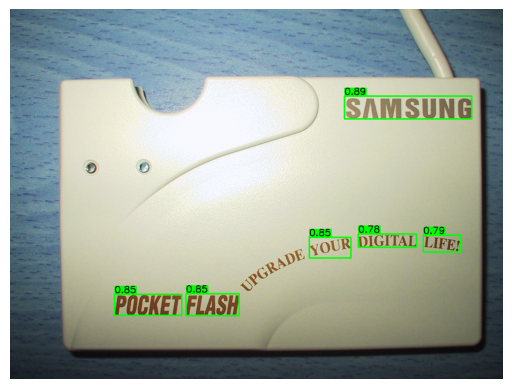

In [25]:
from ultralytics import YOLO

model_path = "runs/detect/train2/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()